In [1]:
!pip install opencv-python
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import json

drive.mount('/content/drive')
print("✅ Drive mounted successfully!")

print(f"\nCurrent directory: {os.getcwd()}")


Mounted at /content/drive
✅ Drive mounted successfully!

Current directory: /content


In [2]:
dataset_zip = "/content/drive/MyDrive/CircuitGuard_Project/new PCB _ds.zip"

if os.path.exists(dataset_zip):
    print("Unzipping PCB dataset...")
    !unzip -q "{dataset_zip}" -d /content/
else:
    print("⚠️ Dataset zip not found. Update path if needed.")

masks_zip = "/content/drive/MyDrive/CircuitGuard_Project/defect_masks.zip"

if os.path.exists(masks_zip):
    print("\nUnzipping defect masks...")
    !unzip -q "{masks_zip}" -d /content/
else:
    print("⚠️ Masks zip not found at:", masks_zip)
    print("💡 Update the path above to match where you uploaded defect_masks.zip")

MASKS_DIR = '/content/defect_masks/defect_masks'
TEST_BASE_DIR = '/content/new PCB _ds/images'
ROI_OUTPUT_DIR = '/content/defect_crops'

os.makedirs(ROI_OUTPUT_DIR, exist_ok=True)

print("PATH VERIFICATION")

print(f" Masks directory: {MASKS_DIR}")
print(f" Exists: {os.path.exists(MASKS_DIR)}")

if os.path.exists(MASKS_DIR):
    categories = [f for f in os.listdir(MASKS_DIR)
                  if os.path.isdir(f"{MASKS_DIR}/{f}") and not f.startswith('.')]
    print(f"  ✅ Categories found: {categories}")

    for cat in categories:
        mask_count = len(glob.glob(f"{MASKS_DIR}/{cat}/*.jpg"))
        print(f"     - {cat}: {mask_count} masks")
else:
    print(f"  Directory not found!")

print(f"\n Test images directory: {TEST_BASE_DIR}")
print(f"  Exists: {os.path.exists(TEST_BASE_DIR)}")

print(f"\n Output directory: {ROI_OUTPUT_DIR}")
print(f"  Created: {os.path.exists(ROI_OUTPUT_DIR)}")


Unzipping PCB dataset...

Unzipping defect masks...
PATH VERIFICATION
 Masks directory: /content/defect_masks/defect_masks
 Exists: True
  ✅ Categories found: ['Missing_hole', 'Open_circuit', 'Mouse_bite', 'Spur', 'Short', 'Spurious_copper']
     - Missing_hole: 115 masks
     - Open_circuit: 116 masks
     - Mouse_bite: 115 masks
     - Spur: 115 masks
     - Short: 116 masks
     - Spurious_copper: 116 masks

 Test images directory: /content/new PCB _ds/images
  Exists: True

 Output directory: /content/defect_crops
  Created: True


In [3]:
# CORE ROI EXTRACTION FUNCTION

def extract_rois_from_mask(mask_path, test_img_path, defect_type, output_dir, min_area=50):
    """
    Extract individual defect ROIs from a binary mask

    Parameters:
    -----------
    mask_path : str
        Path to binary mask image (black & white)
    test_img_path : str
        Path to original test image
    defect_type : str
        Category name (Short, Spur, open, etc.)
    output_dir : str
        Base directory to save cropped ROIs
    min_area : int
        Minimum contour area in pixels (filter noise)

    Returns:
    --------
    list : Information about extracted ROIs
    """

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

    if mask is None or test_img is None:
        return []

    # Finding contours (boundaries of white regions in mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtering contours by area (removing small noise)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Preparing output directory
    base_name = os.path.splitext(os.path.basename(test_img_path))[0]
    category_output_dir = f"{output_dir}/{defect_type}"
    os.makedirs(category_output_dir, exist_ok=True)

    extracted_rois = []

    # Extracting ROI for each contour
    for i, contour in enumerate(valid_contours):
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)

        # Add padding (10 pixels on each side)
        padding = 10
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(test_img.shape[1], x + w + padding)
        y2 = min(test_img.shape[0], y + h + padding)

        # Cropping ROI from original test image
        roi = test_img[y1:y2, x1:x2]

        # Resizing to 128×128 (EfficientNet input size)
        roi_resized = cv2.resize(roi, (128, 128))

        # Saving cropped ROI
        roi_filename = f"{category_output_dir}/{base_name}_roi_{i+1}.jpg"
        cv2.imwrite(roi_filename, roi_resized)

        # Storing ROI information
        extracted_rois.append({
            'filename': roi_filename,
            'bbox': (x, y, w, h),
            'area': float(cv2.contourArea(contour)),
            'original_size': (x2-x1, y2-y1),
            'resized_size': (128, 128)
        })

    return extracted_rois

print("✅ ROI extraction function defined!")
print("\n📊 Function: extract_rois_from_mask()")
print("   - Finds contours in binary mask using cv2.findContours()")
print("   - Extracts bounding boxes with cv2.boundingRect()")
print("   - Crops ROIs with 10px padding")
print("   - Resizes to 128×128 for EfficientNet")
print("   - Saves to defect_crops/ folder")


✅ ROI extraction function defined!

📊 Function: extract_rois_from_mask()
   - Finds contours in binary mask using cv2.findContours()
   - Extracts bounding boxes with cv2.boundingRect()
   - Crops ROIs with 10px padding
   - Resizes to 128×128 for EfficientNet
   - Saves to defect_crops/ folder


TESTING ROI EXTRACTION ON SAMPLE IMAGE
📂 Category: Missing_hole
  Mask: 11_missing_hole_08_mask.jpg
  Image: 11_missing_hole_08.jpg

✅ Extracted 5 ROI(s)!

📊 ROI Details:

  ROI 1:
    Area: 778 pixels
    Bounding box (x,y,w,h): (1328, 1560, 40, 32)
    Original size: (60, 52)
    Resized to: (128, 128)
    Saved: 11_missing_hole_08_roi_1.jpg

  ROI 2:
    Area: 794 pixels
    Bounding box (x,y,w,h): (448, 1560, 40, 32)
    Original size: (60, 52)
    Resized to: (128, 128)
    Saved: 11_missing_hole_08_roi_2.jpg

  ROI 3:
    Area: 949 pixels
    Bounding box (x,y,w,h): (1139, 1296, 45, 40)
    Original size: (65, 60)
    Resized to: (128, 128)
    Saved: 11_missing_hole_08_roi_3.jpg

  ROI 4:
    Area: 984 pixels
    Bounding box (x,y,w,h): (1448, 992, 40, 32)
    Original size: (60, 52)
    Resized to: (128, 128)
    Saved: 11_missing_hole_08_roi_4.jpg

  ROI 5:
    Area: 872 pixels
    Bounding box (x,y,w,h): (736, 984, 40, 40)
    Original size: (60, 60)
    Resized to: (128, 128

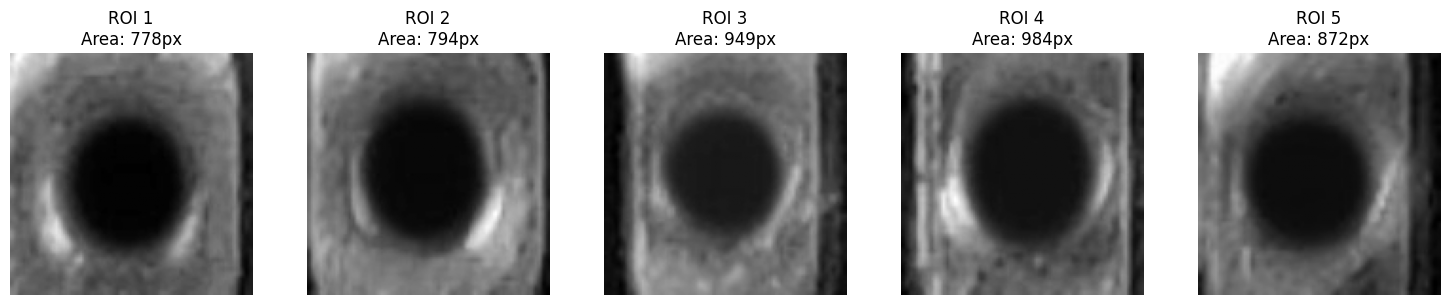

In [4]:
# TESTING ON SINGLE SAMPLE

print("TESTING ROI EXTRACTION ON SAMPLE IMAGE")

# Auto-detect first available category and image
categories = [f for f in os.listdir(MASKS_DIR)
              if os.path.isdir(f"{MASKS_DIR}/{f}") and not f.startswith('.')]

if len(categories) > 0:
    test_category = categories[0]  # Using first category
    mask_files = glob.glob(f"{MASKS_DIR}/{test_category}/*.jpg")

    if len(mask_files) > 0:
        # Using first mask file
        test_mask = mask_files[0]
        mask_basename = os.path.basename(test_mask).replace('_mask.jpg', '.jpg')
        test_img = f"{TEST_BASE_DIR}/{test_category}/{mask_basename}"

        print(f"📂 Category: {test_category}")
        print(f"  Mask: {os.path.basename(test_mask)}")
        print(f"  Image: {os.path.basename(test_img)}")

        # Extracting ROIs
        rois = extract_rois_from_mask(test_mask, test_img, test_category, ROI_OUTPUT_DIR)

        print(f"\n✅ Extracted {len(rois)} ROI(s)!")

        if len(rois) > 0:
            print("\n📊 ROI Details:")
            for i, roi_info in enumerate(rois):
                print(f"\n  ROI {i+1}:")
                print(f"    Area: {roi_info['area']:.0f} pixels")
                print(f"    Bounding box (x,y,w,h): {roi_info['bbox']}")
                print(f"    Original size: {roi_info['original_size']}")
                print(f"    Resized to: {roi_info['resized_size']}")
                print(f"    Saved: {os.path.basename(roi_info['filename'])}")

            # Visualizing extracted ROIs
            print("\n📸 Visualizing extracted ROIs...")
            num_display = min(len(rois), 5)

            fig, axes = plt.subplots(1, num_display, figsize=(15, 3))
            if num_display == 1:
                axes = [axes]

            for i in range(num_display):
                roi_img = cv2.imread(rois[i]['filename'], cv2.IMREAD_GRAYSCALE)
                axes[i].imshow(roi_img, cmap='gray')
                axes[i].set_title(f"ROI {i+1}\nArea: {rois[i]['area']:.0f}px")
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("\n⚠️ No ROIs extracted. Mask may not have white regions.")
    else:
        print(f"⚠️ No mask files found in {test_category}")
else:
    print("⚠️ No categories found in masks directory")


 VISUALIZING CONTOUR DETECTION WITH BOUNDING BOXES


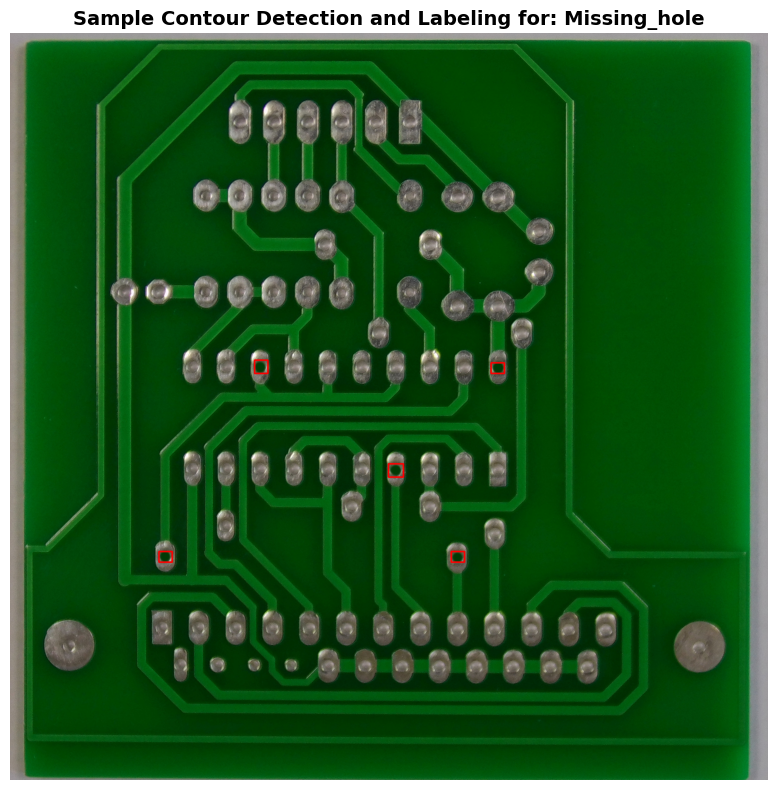

✅ Detected 5 contours in Missing_hole image



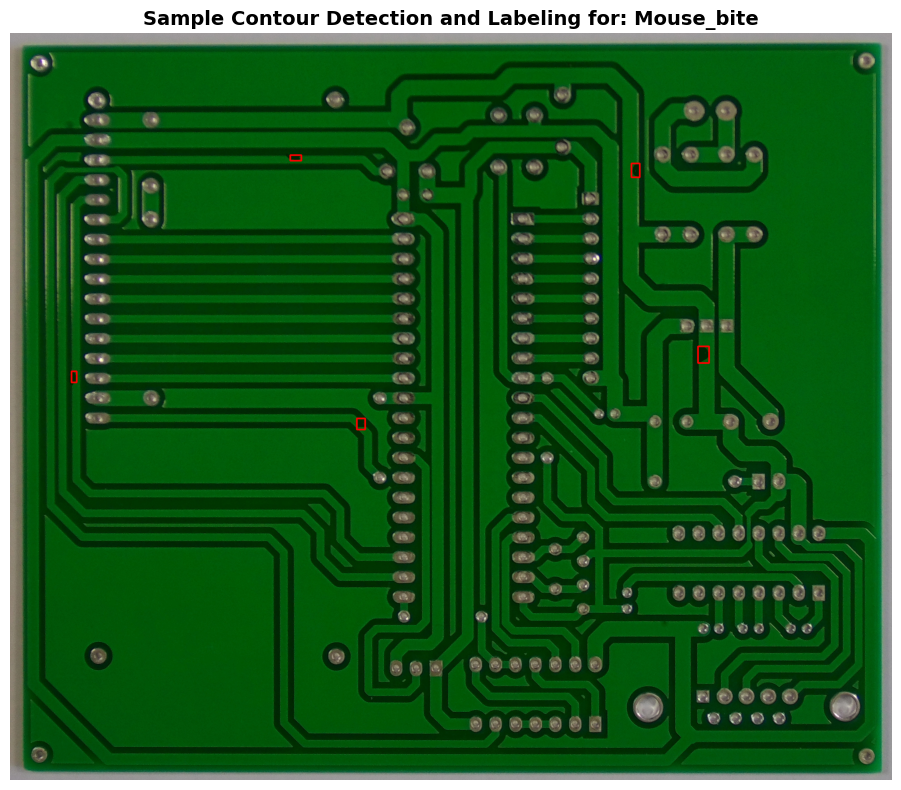

✅ Detected 5 contours in Mouse_bite image



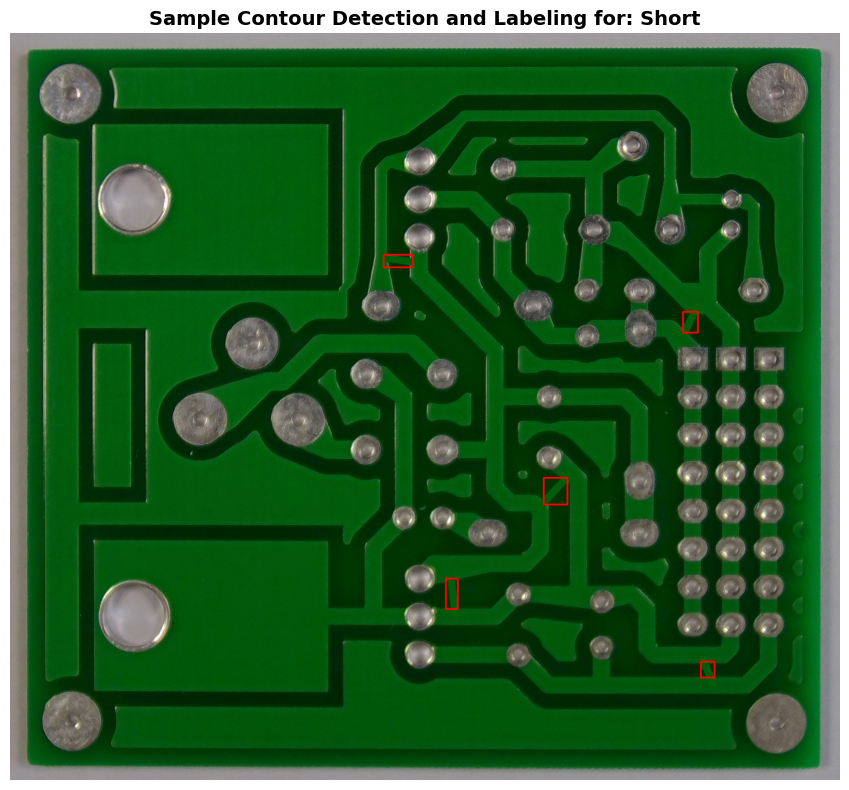

✅ Detected 5 contours in Short image



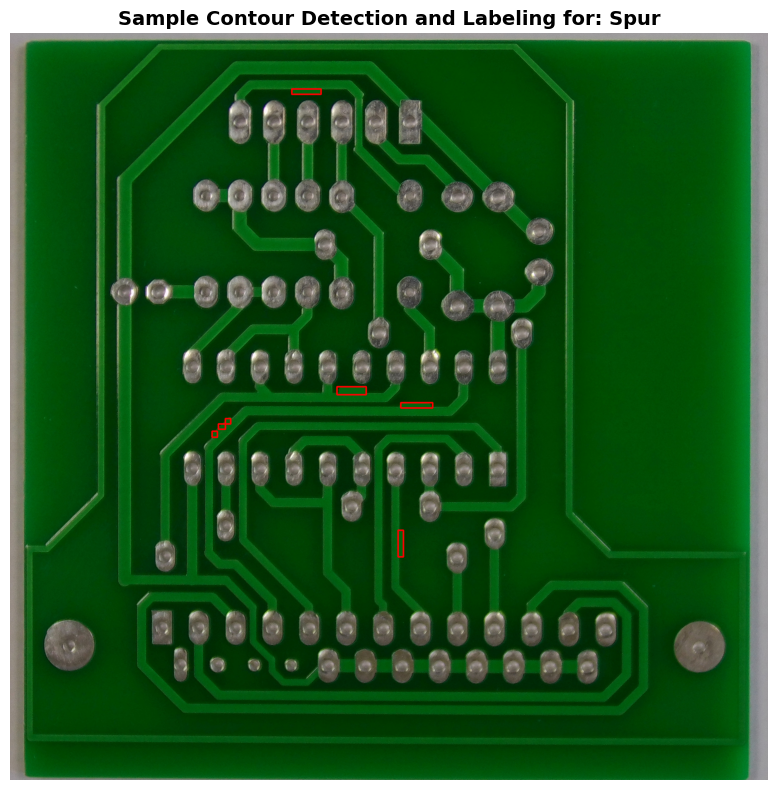

✅ Detected 7 contours in Spur image



In [5]:
# VISUALIZING CONTOURS WITH RED BOXES

def visualize_contours_on_image(mask_path, test_img_path, category_name):
    """Drawing red bounding boxes on original image to show detected contours"""

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.imread(test_img_path)
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Finding contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtering by minimum area
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]

    # Drawing red boxes
    img_with_boxes = test_img_rgb.copy()
    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (255, 0, 0), 3)  # Red boxes

    # Displaying
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_boxes)
    plt.title(f'Sample Contour Detection and Labeling for: {category_name}',
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"✅ Detected {len(valid_contours)} contours in {category_name} image")

# Testing on samples from different categories
print(" VISUALIZING CONTOUR DETECTION WITH BOUNDING BOXES")

categories_to_show = ['Missing_hole', 'Mouse_bite', 'Short', 'Spur']

for cat in categories_to_show:
    cat_mask_dir = f"{MASKS_DIR}/{cat}"
    cat_test_dir = f"{TEST_BASE_DIR}/{cat}"

    if os.path.exists(cat_mask_dir):
        mask_files = glob.glob(f"{cat_mask_dir}/*.jpg")
        if len(mask_files) > 0:
            test_mask = mask_files[0]
            mask_basename = os.path.basename(test_mask).replace('_mask.jpg', '.jpg')
            test_img = f"{cat_test_dir}/{mask_basename}"

            if os.path.exists(test_img):
                visualize_contours_on_image(test_mask, test_img, cat)
                print()


In [6]:
# BATCH PROCESSING FOR ALL CATEGORIES

def process_all_categories():
    """Process all defect categories and extract ROIs"""

    # Auto-detecting categories
    categories = [f for f in os.listdir(MASKS_DIR)
                 if os.path.isdir(f"{MASKS_DIR}/{f}") and not f.startswith('.')]

    print(f"\n Found {len(categories)} categories:")
    for cat in categories:
        mask_count = len(glob.glob(f"{MASKS_DIR}/{cat}/*.jpg"))
        print(f"  - {cat}: {mask_count} masks")

    all_results = {}
    total_rois = 0

    for category in categories:
        print(f"\n{'='*60}")
        print(f"📂 Processing {category} category...")

        mask_dir = f"{MASKS_DIR}/{category}"
        test_dir = f"{TEST_BASE_DIR}/{category}"

        # Get all masks
        mask_files = glob.glob(f"{mask_dir}/*.jpg")

        if len(mask_files) == 0:
            print(f"  ⚠️ No masks found in {category}")
            continue

        category_rois = []

        for mask_file in tqdm(mask_files, desc=f"  {category}"):
            # Get corresponding test image
            mask_basename = os.path.basename(mask_file).replace('_mask.jpg', '.jpg')
            test_file = f"{test_dir}/{mask_basename}"

            if not os.path.exists(test_file):
                continue

            # Extracting ROIs
            rois = extract_rois_from_mask(mask_file, test_file, category, ROI_OUTPUT_DIR)
            category_rois.extend(rois)

        all_results[category] = {
            'total_masks_processed': len(mask_files),
            'total_rois_extracted': len(category_rois),
            'avg_rois_per_image': round(len(category_rois) / len(mask_files), 2) if mask_files else 0
        }

        total_rois += len(category_rois)

        print(f"  ✅ {category}: {len(category_rois)} ROIs extracted from {len(mask_files)} masks")

    # Saving report
    report = {
        'total_rois_extracted': total_rois,
        'total_categories': len(categories),
        'categories': all_results,
        'extraction_date': '2025-10-24',
        'roi_size': '128x128 pixels',
        'min_area_threshold': 50
    }

    report_path = f"{ROI_OUTPUT_DIR}/roi_extraction_report.json"
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)

    print(" ROI EXTRACTION COMPLETE!")
    print(f"\n SUMMARY:")
    print(f"  Total ROIs extracted: {total_rois}")
    print(f"  Categories processed: {len(categories)}")
    print(f"  ROI size: 128×128 pixels")
    print(f"  Output directory: {ROI_OUTPUT_DIR}/")
    print(f"  Report saved: {report_path}")

    return report
report = process_all_categories()



 Found 6 categories:
  - Missing_hole: 115 masks
  - Open_circuit: 116 masks
  - Mouse_bite: 115 masks
  - Spur: 115 masks
  - Short: 116 masks
  - Spurious_copper: 116 masks

📂 Processing Missing_hole category...


  Missing_hole: 100%|██████████| 115/115 [00:03<00:00, 35.55it/s]


  ✅ Missing_hole: 497 ROIs extracted from 115 masks

📂 Processing Open_circuit category...


  Open_circuit: 100%|██████████| 116/116 [00:03<00:00, 30.99it/s]


  ✅ Open_circuit: 4624 ROIs extracted from 116 masks

📂 Processing Mouse_bite category...


  Mouse_bite: 100%|██████████| 115/115 [00:03<00:00, 31.29it/s]


  ✅ Mouse_bite: 3803 ROIs extracted from 115 masks

📂 Processing Spur category...


  Spur: 100%|██████████| 115/115 [00:03<00:00, 31.76it/s]


  ✅ Spur: 4070 ROIs extracted from 115 masks

📂 Processing Short category...


  Short: 100%|██████████| 116/116 [00:03<00:00, 30.91it/s]


  ✅ Short: 5054 ROIs extracted from 116 masks

📂 Processing Spurious_copper category...


  Spurious_copper: 100%|██████████| 116/116 [00:03<00:00, 32.67it/s]

  ✅ Spurious_copper: 3628 ROIs extracted from 116 masks
 ROI EXTRACTION COMPLETE!

 SUMMARY:
  Total ROIs extracted: 21676
  Categories processed: 6
  ROI size: 128×128 pixels
  Output directory: /content/defect_crops/
  Report saved: /content/defect_crops/roi_extraction_report.json



📂 Missing_hole:
  Masks processed: 115
  ROIs extracted: 497
  Average ROIs per image: 4.32

📂 Open_circuit:
  Masks processed: 116
  ROIs extracted: 4624
  Average ROIs per image: 39.86

📂 Mouse_bite:
  Masks processed: 115
  ROIs extracted: 3803
  Average ROIs per image: 33.07

📂 Spur:
  Masks processed: 115
  ROIs extracted: 4070
  Average ROIs per image: 35.39

📂 Short:
  Masks processed: 116
  ROIs extracted: 5054
  Average ROIs per image: 43.57

📂 Spurious_copper:
  Masks processed: 116
  ROIs extracted: 3628
  Average ROIs per image: 31.28

Sample ROIs from each category:


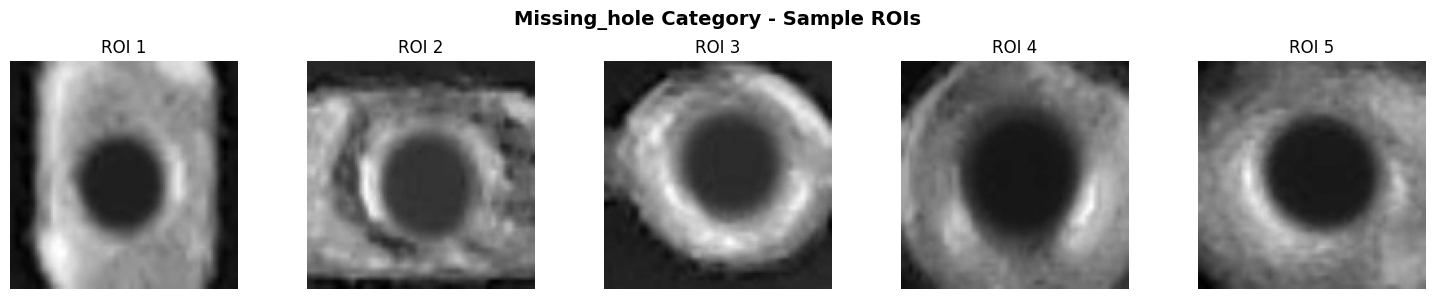

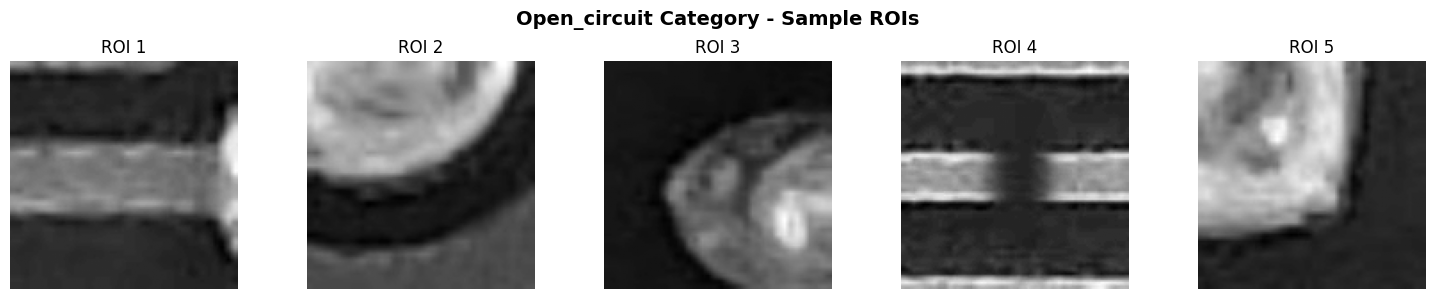

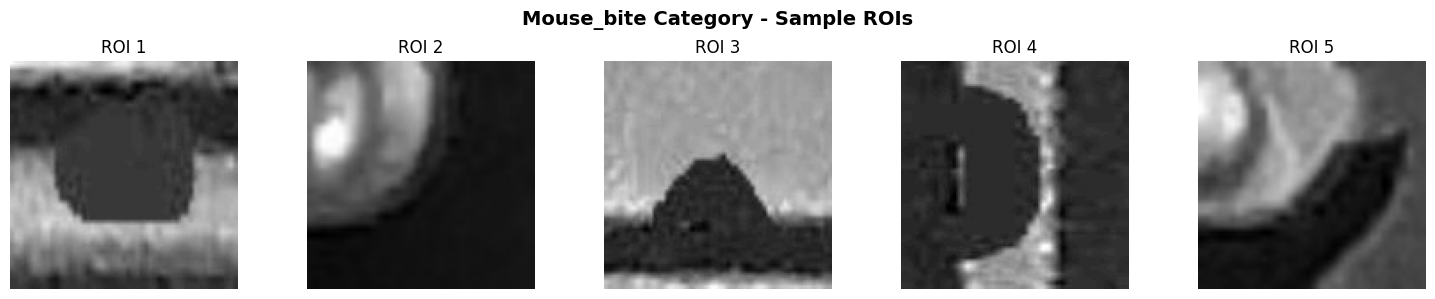

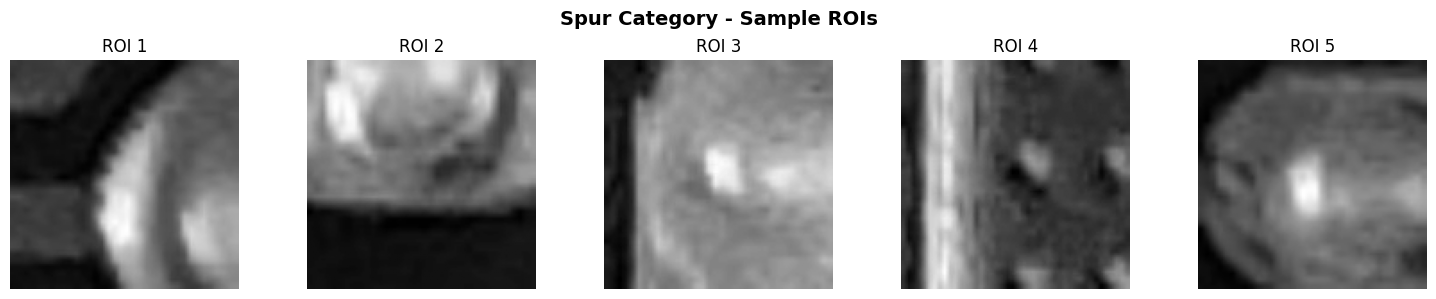

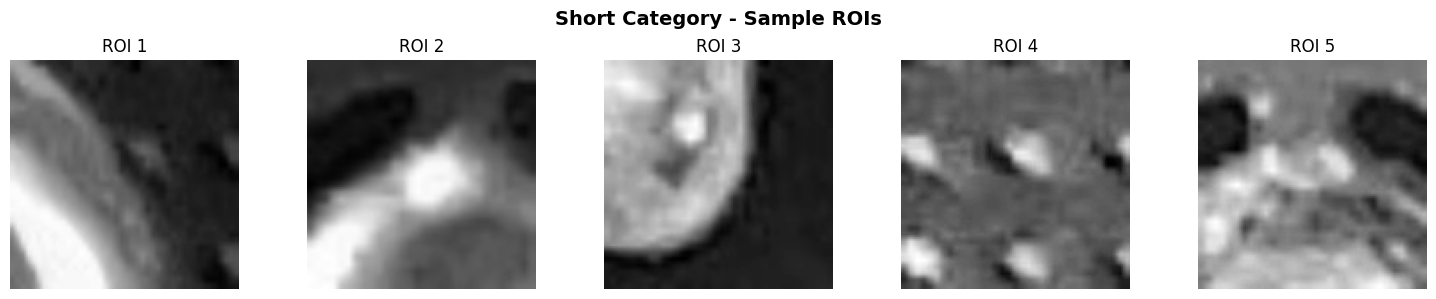

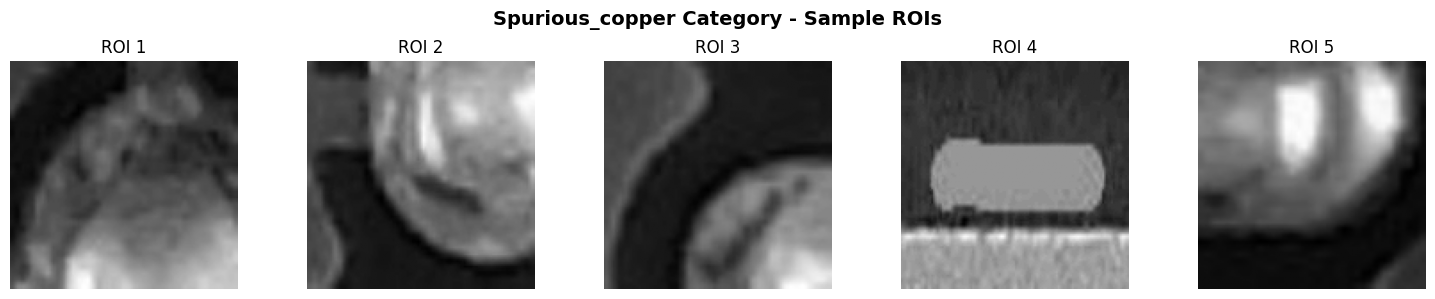

In [7]:
# DISPLAYING SUMMARY STATISTICS

for category, stats in report['categories'].items():
    print(f"\n📂 {category}:")
    print(f"  Masks processed: {stats['total_masks_processed']}")
    print(f"  ROIs extracted: {stats['total_rois_extracted']}")
    print(f"  Average ROIs per image: {stats['avg_rois_per_image']}")

# Showing sample ROIs from each category
print("\nSample ROIs from each category:")
for category in report['categories'].keys():
    roi_dir = f"{ROI_OUTPUT_DIR}/{category}"
    roi_files = glob.glob(f"{roi_dir}/*.jpg")[:5]  # Get first 5

    if len(roi_files) > 0:
        fig, axes = plt.subplots(1, len(roi_files), figsize=(15, 3))
        if len(roi_files) == 1:
            axes = [axes]

        fig.suptitle(f'{category} Category - Sample ROIs', fontsize=14, fontweight='bold')

        for i, roi_file in enumerate(roi_files):
            roi_img = cv2.imread(roi_file, cv2.IMREAD_GRAYSCALE)
            axes[i].imshow(roi_img, cmap='gray')
            axes[i].set_title(f"ROI {i+1}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


In [8]:
print("  Zipping defect_crops folder...")

!zip -r /content/defect_crops.zip /content/defect_crops

print("\n✅ Zipping complete!")
print(f"📁 File: /content/defect_crops.zip")

file_size_mb = os.path.getsize('/content/defect_crops.zip') / (1024 * 1024)
print(f"💾 Size: {file_size_mb:.2f} MB")
from google.colab import files
files.download('/content/defect_crops.zip')

print("\n✅ Download complete!")

Streaming output truncated to the last 5000 lines.
  adding: content/defect_crops/Short/01_short_07_roi_151.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_13_roi_97.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_17_roi_141.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_17_roi_100.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_09_roi_78.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_12_roi_114.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_09_roi_134.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_01_roi_11.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_15_roi_10.jpg (stored 0%)
  adding: content/defect_crops/Short/11_short_09_roi_2.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_13_roi_108.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_05_roi_153.jpg (stored 0%)
  adding: content/defect_crops/Short/01_short_20_roi_62.jpg (stored 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!
